In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Importing other libraries that are required
import cv2
import tensorflow as tf
import argparse
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

import matplotlib.pyplot as plt

In [3]:
trainf = pd.read_csv('/kaggle/input/hackerearth-holiday-season/dataset/train.csv')
print('Train shape is : ',trainf.shape)
trainf.head()
labels=len(trainf.Class.unique())
labels

Train shape is :  (6469, 2)


6

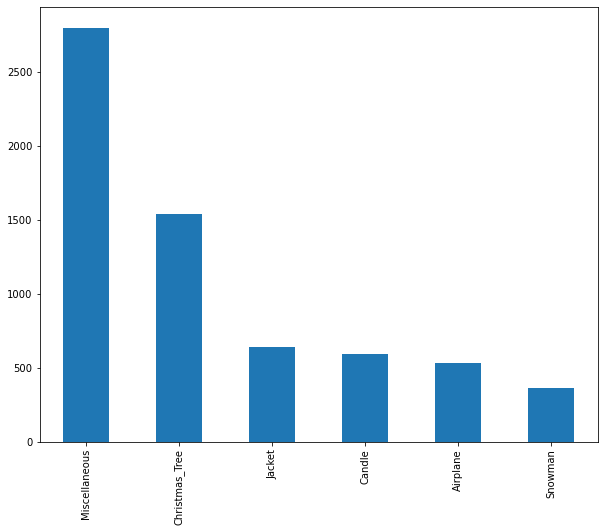

In [4]:
#Plotting the o/p class distribution in the train dataset
trainf.Class.value_counts().plot(kind='bar',figsize=(10,8))

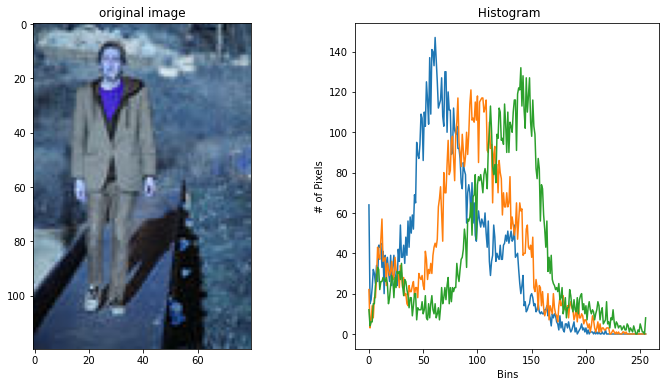

In [5]:
#Reading the image and plotting the image and the histograms of the RGB channels
imag=cv2.imread('../input/hackerearth-holiday-season/dataset/train/image1000.jpg')
#gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)
#hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

histr = cv2.calcHist([imag],[0],None,[256],[0,256]) 
histg = cv2.calcHist([imag],[1],None,[256],[0,256]) 
histb = cv2.calcHist([imag],[2],None,[256],[0,256]) 
    
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(6*2, 3*2)

ax1.set_title('original image')
ax1.imshow(imag)
ax2.set_title(" Histogram")
ax2.set_xlabel("Bins")
ax2.set_ylabel("# of Pixels")
ax2.plot(histr)
ax2.plot(histg)
ax2.plot(histb)


#plt.xlim([0, 256])
plt.show()

### Shuffling the images b4 and creating partition dictionary for train and validation

In [6]:
## Shuffling the images b4 reading the images
train_data_dir = '../input/hackerearth-holiday-season/dataset/train/'
traindataids=os.listdir(train_data_dir)
traindataids=[g for g in traindataids if '.jpg' in g ] #To avoid the non jpeg file present in the directory
import random 
random.shuffle(traindataids)

train_ids=random.sample(traindataids,int(.9*len(traindataids)))
val_ids= [id for id in traindataids if id not in train_ids ]

In [7]:
print('First 10 images : ',train_ids[:10])
print('Length of train set : ', len(train_ids))
print('First 10 images : ',val_ids[:10])
print('Length of val set : ', len(val_ids))

First 10 images :  ['image7995.jpg', 'image7354.jpg', 'image1504.jpg', 'image937.jpg', 'image9563.jpg', 'image9589.jpg', 'image4199.jpg', 'image3066.jpg', 'image7555.jpg', 'image8062.jpg']
Length of train set :  5822
First 10 images :  ['image1830.jpg', 'image4385.jpg', 'image5789.jpg', 'image2860.jpg', 'image8177.jpg', 'image6447.jpg', 'image5485.jpg', 'image999.jpg', 'image5800.jpg', 'image5720.jpg']
Length of val set :  647


In [8]:
## creating partition dictionary for train and validation
partition={}
partition['train'] =train_ids
partition['validation'] =val_ids
partition

{'train': ['image7995.jpg',
  'image7354.jpg',
  'image1504.jpg',
  'image937.jpg',
  'image9563.jpg',
  'image9589.jpg',
  'image4199.jpg',
  'image3066.jpg',
  'image7555.jpg',
  'image8062.jpg',
  'image8634.jpg',
  'image1174.jpg',
  'image2414.jpg',
  'image7208.jpg',
  'image9897.jpg',
  'image9205.jpg',
  'image5094.jpg',
  'image7482.jpg',
  'image1116.jpg',
  'image1908.jpg',
  'image4078.jpg',
  'image2993.jpg',
  'image7884.jpg',
  'image5843.jpg',
  'image2654.jpg',
  'image8737.jpg',
  'image6820.jpg',
  'image4310.jpg',
  'image922.jpg',
  'image6767.jpg',
  'image7972.jpg',
  'image5224.jpg',
  'image4129.jpg',
  'image3108.jpg',
  'image9615.jpg',
  'image9079.jpg',
  'image5035.jpg',
  'image421.jpg',
  'image4559.jpg',
  'image6853.jpg',
  'image537.jpg',
  'image7544.jpg',
  'image3438.jpg',
  'image9585.jpg',
  'image7784.jpg',
  'image8213.jpg',
  'image1184.jpg',
  'image8683.jpg',
  'image6103.jpg',
  'image2835.jpg',
  'image813.jpg',
  'image3671.jpg',
  'image

In [9]:
# list_IDs=traindataids

In [11]:
trainf.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [12]:
partition.keys()

dict_keys(['train', 'validation'])

### Creating the Data generators for Training set(with data augmentation) and for Validation set.

In [13]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### train and valid
partition.keys()
# trainf['labelstr'] = trainf['category'].apply(lambda x : str(x)) # This is required because image data generator shd know it's a class and not a number

train_df=trainf[trainf['Image'].isin(partition['train'])]
valid_df=trainf[trainf['Image'].isin(partition['validation'])]

print(train_df.shape,valid_df.shape)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
print(train_datagen)

# In below case we are getting data from dataframe, similarly we can take it from directory with a list of the values mapping the image and categ
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_data_dir,
        x_col="Image",
        y_col='Class',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical') #categorical for multi class o/p's

# We are not doing augmentation in validation data thinking it's a test data as we don't augment the test data in reality
valid_datagen = ImageDataGenerator(rescale=1./255)
print(valid_datagen)

validation_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=train_data_dir,
        x_col="Image",
        y_col='Class',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical') #categorical for multi class o/p's

(5822, 2) (647, 2)
Found 5822 validated image filenames belonging to 6 classes.
Found 647 validated image filenames belonging to 6 classes.


In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Transfer Learning : inception_resnet_v2 with Imagenet dataset weights

In [30]:
from keras.applications import inception_resnet_v2
from keras.preprocessing.image import img_to_array
import pydot

In [31]:
#Downloading the weights of the pre-trained model and plotting the architecture 
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.utils.vis_utils import plot_model
model_InceptionResNetV2 = InceptionResNetV2()
plot_model(model_InceptionResNetV2, to_file='InceptionResNetV2.png')

225214464/225209952 [==============================] - 1s 0us/step


In [ ]:
# imgsize=224  
#     ## customizing the model using vgg architecture
# inception_resnet_v2_model_wtl = inception_resnet_v2.InceptionResNetV2(weights='imagenet',input_shape=(imgsize,imgsize,3),
#                         include_top=False) #Include_top is False as we don't need the o/p of the vgg model 
# #     instead we will build the last few layers
# inception_resnet_v2_model_wtl.summary()

In [43]:
#Creating the Tranfer learning function

from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Flatten
from keras import optimizers
from keras.models import Model


def transferlearn_model_inception_resnet_v2(nclass):
## model architecture
    
    imgsize=224  
    ## customizing the model using resnet50 architecture
    inception_resnet_v2_model_wtl = inception_resnet_v2.InceptionResNetV2(weights='imagenet',input_shape=(imgsize,imgsize,3),
                        include_top=False) #Include_top is False as we don't need the o/p of the vgg model 
#     instead we will build the last few layers
    #inception_resnet_v2_model_wtl.summary()


    ## stacking vgg with custom layers

    layername='conv_7b_bn'
    
    #This will give the o//p of the block3_conv3 layer
    mymodel=Model(inputs=inception_resnet_v2_model_wtl.input,outputs=inception_resnet_v2_model_wtl.get_layer(layername).output)
    #mymodel.summary()


    newmodel1=Sequential()
    newmodel1.add(mymodel)

    newmodel1.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    newmodel1.add(MaxPooling2D((2,2),padding='same'))

    newmodel1.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    newmodel1.add(MaxPooling2D((2,2),padding='same'))


    newmodel1.add(Conv2D(256,(3,3),activation='relu',padding='same'))
    newmodel1.add(MaxPooling2D((2,2),padding='same'))

    newmodel1.add(GlobalAveragePooling2D())
    newmodel1.add(Dense(64,activation='relu'))
    newmodel1.add(BatchNormalization())

    newmodel1.add(Dense(nclass,activation='softmax'))

    # The below code will freeze the layer 0(which we got from the vgg) so that weights won't be updated while training the new data on the new model.
    newmodel1.layers[0].trainable=False
    #newmodel1.summary()

    newmodel1.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    return newmodel1

In [44]:
model_transferlearn_inception_resnet_v2=transferlearn_model_inception_resnet_v2(6)
model_transferlearn_inception_resnet_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 5, 5, 1536)        54336736  
_________________________________________________________________
conv2d_1627 (Conv2D)         (None, 5, 5, 128)         1769600   
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_1628 (Conv2D)         (None, 3, 3, 128)         147584    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_1629 (Conv2D)         (None, 2, 2, 256)         295168    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 1, 1, 256)        

In [46]:
#Library to plot the Training/Validation Accuracy and Loss using the callback function
!pip install livelossplot

  Using cached livelossplot-0.5.4-py3-none-any.whl (22 kB)
  Using cached tornado-6.1-cp37-cp37m-manylinux2010_x86_64.whl (428 kB)
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.0.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


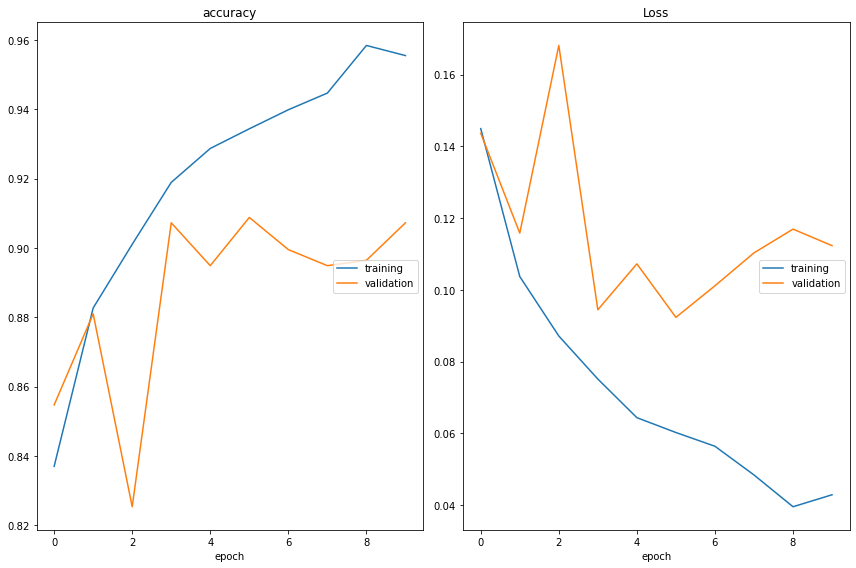

accuracy
	training         	 (min:    0.837, max:    0.958, cur:    0.956)
	validation       	 (min:    0.825, max:    0.909, cur:    0.907)
Loss
	training         	 (min:    0.040, max:    0.145, cur:    0.043)
	validation       	 (min:    0.092, max:    0.168, cur:    0.112)
182/182 [==============================] - 74s 406ms/step - loss: 0.0429 - accuracy: 0.9555 - val_loss: 0.1123 - val_accuracy: 0.9073


In [47]:
from livelossplot.keras import PlotLossesCallback
from keras.callbacks import CSVLogger
TRAINING_LOGS_FILE = "./training_logs.csv"
model_transferlearn_inception_resnet_v2.fit_generator(generator=train_generator,
                    validation_data=validation_generator,epochs = 10,
                    callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,append=False,separator=";")])

In [48]:
a = pd.read_csv('./training_logs.csv')
a.head()

,epoch;accuracy;loss;val_accuracy;val_loss
0,0;0.8369975686073303;0.14493003487586975;0.854...
1,1;0.8826863765716553;0.10370359569787979;0.880...
2,2;0.901064932346344;0.08713683485984802;0.8253...
3,3;0.9189282059669495;0.07514136284589767;0.907...
4,4;0.928718626499176;0.06438372284173965;0.8948...


In [49]:
### saving model
model_transferlearn_inception_resnet_v2.save('./inception_resnet_v2.h5')
### loading mode

###model=keras.models.load_model('./inception_resnet_v2.h5')

### Predicting the classes on Test set and writing it to csv file for submission

In [50]:
classes = train_generator.class_indices
classes = dict((v,k) for k,v in classes.items())
classes = [classes[k] for k in classes]
classes

['Airplane', 'Candle', 'Christmas_Tree', 'Jacket', 'Miscellaneous', 'Snowman']

In [51]:
from keras.preprocessing import image
Image = []
prediction = []
import time
from tqdm import tqdm


for i, file in tqdm(enumerate(os.listdir('../input/hackerearth-holiday-season/dataset/test/'))):
    Image.append(file)
    file = '../input/hackerearth-holiday-season/dataset/test/' + file

    img = image.load_img(file, target_size=(224,224,3)) 
    img = image.img_to_array(img)
    img = img/255
    pred = model_transferlearn_inception_resnet_v2.predict(img.reshape(1,224,224,3))

    prediction.append(classes[np.argmax(pred[0])])

3489it [04:20, 13.41it/s]


In [52]:
data1=pd.DataFrame((zip(Image, prediction)),columns=['Image','Class'])
data1.head()

,Image,Class
0,image7761.jpg,Miscellaneous
1,image3202.jpg,Miscellaneous
2,image688.jpg,Snowman
3,image233.jpg,Candle
4,image4332.jpg,Christmas_Tree


In [53]:
data1.to_csv('TL_inception_resnet_v2_output.csv', index=False)